In [1]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from reader import generic_reader
import seaborn as sns
import os
import ast
os.environ["PATH"] += r";C:\Program Files\Graphviz\bin"
import graphviz

**Decision tree to danish actors** 

We will create a model to predict the gender of a Danish actor based on their number of movies and age.

In [2]:
df_danish_actors = generic_reader.read_csv_file_to_data_frame("movie_data/danish_actors.csv")

In [3]:
print(df_danish_actors.columns)

Index(['actor_id', 'name', 'gender', 'birthday', 'deathday', 'movie_count',
       'age'],
      dtype='object')


Dropping columns from the dataframe which won't be part for the model

In [4]:
columns_to_drop = ['actor_id', 'name', 'deathday', 'birthday']

df_clean_actors = df_danish_actors.drop(columns=columns_to_drop)

Selecting the feature input columns, age and movie_count, and the column to predict, gender.

In [5]:
feature_cols = [
    'age',          
    'movie_count' 
]
label_col = 'gender' 

In [6]:
X = df_clean_actors[feature_cols].values
y = df_clean_actors[label_col].values

In [7]:
female = X[y == 1] 
male = X[y == 2]   

In [8]:
set_prop = 0.20

In [9]:
seed = 10

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=set_prop, random_state=seed)

In [11]:
params = {'max_depth': 4}
classifier = DecisionTreeClassifier(**params)
randomclassifier = RandomForestClassifier(n_estimators = 100, max_depth = 4)

In [12]:
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [13]:
dot_data = tree.export_graphviz(
    classifier,
    out_file=None,
    feature_names=feature_cols,
    class_names=['Unknown', 'female', 'male', 'No-binary'],  # '' for index 0
    filled=True, rounded=True
)

In [14]:
graph = graphviz.Source(dot_data)
graph.render("danish_actor")

'danish_actor.pdf'

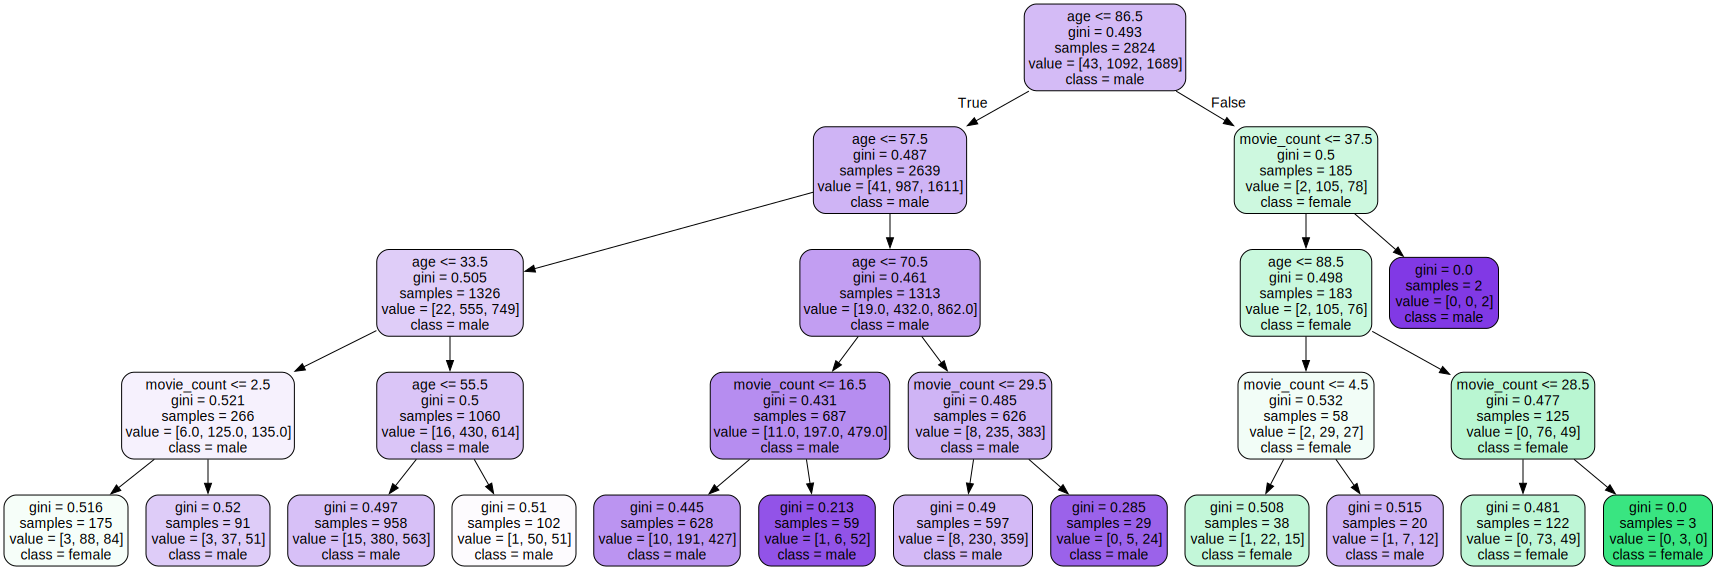

In [15]:
graph

In [16]:
scoring = 'accuracy'

In [17]:
y_testp = classifier.predict(X_test)
y_testp

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1,
       2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2,

In [18]:
y_test

array([1, 2, 2, 2, 1, 2, 0, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 0, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1,
       1, 1, 2, 0, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1,
       1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1,
       2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2,
       1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1,
       2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2,
       1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1,

In [19]:
print ("Accuracy is ", accuracy_score(y_test,y_testp))

Accuracy is  0.5920679886685553


In [20]:
confusion_mat = confusion_matrix(y_test,y_testp)
confusion_mat

array([[  0,   1,  10],
       [  0,  35, 234],
       [  0,  43, 383]])

In [21]:
confusion = pd.crosstab(y_test,y_testp)
confusion

col_0,1,2
row_0,,
0,1,10
1,35,234
2,43,383


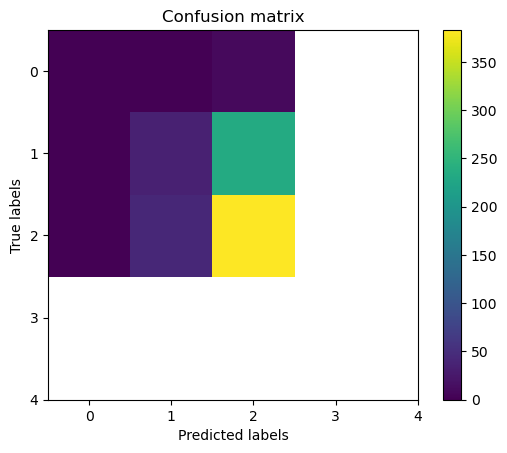

In [22]:
plt.imshow(confusion_mat, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
ticks = np.arange(5)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

<Axes: >

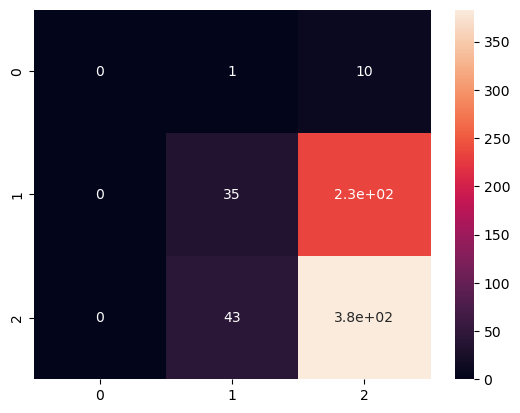

In [23]:
sns.heatmap(confusion_mat, annot=True)

In [24]:
randomclassifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=4)

In [25]:
best_accuracy = 0
best_tree = None

# Loop through all trees in the random forest
for tree_estimator in randomclassifier.estimators_:
    y_pred = tree_estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    if acc > best_accuracy:
        best_accuracy = acc
        best_tree = tree_estimator

dot_data_best = tree.export_graphviz(
    best_tree,
    out_file=None,
    feature_names=feature_cols,
    class_names=["",'female', 'male'],
    filled=True,
    rounded=True
)


In [26]:
graph_best = graphviz.Source(dot_data_best)
graph_best.render("best_random_forest_tree")

'best_random_forest_tree.pdf'

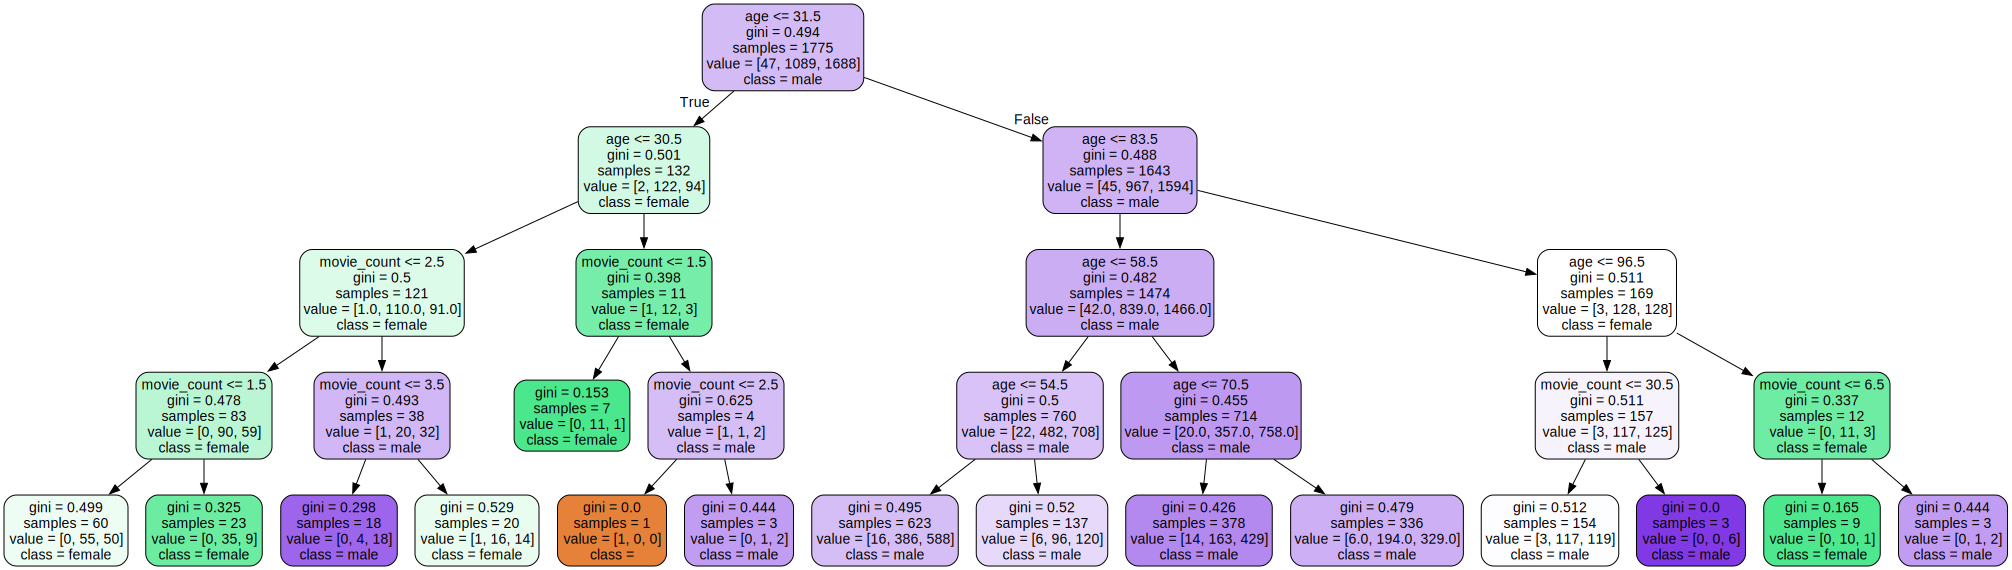

In [27]:
graph_best

In [28]:
scoring_random = 'accuracy'

In [29]:
y_testp = randomclassifier.predict(X_test)
y_testp

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,

In [30]:
y_test

array([1, 2, 2, 2, 1, 2, 0, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 0, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1,
       1, 1, 2, 0, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1,
       1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1,
       2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2,
       1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1,
       2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2,
       1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1,

In [31]:
print ("Accuracy is ", accuracy_score(y_test,y_testp))

Accuracy is  0.5878186968838527


In [32]:
confusion_mat_random = confusion_matrix(y_test,y_testp)
confusion_mat_random

array([[  0,   1,  10],
       [  0,  10, 259],
       [  0,  21, 405]])

In [33]:
confusion_random = pd.crosstab(y_test,y_testp)
confusion_random

col_0,1,2
row_0,,
0,1,10
1,10,259
2,21,405


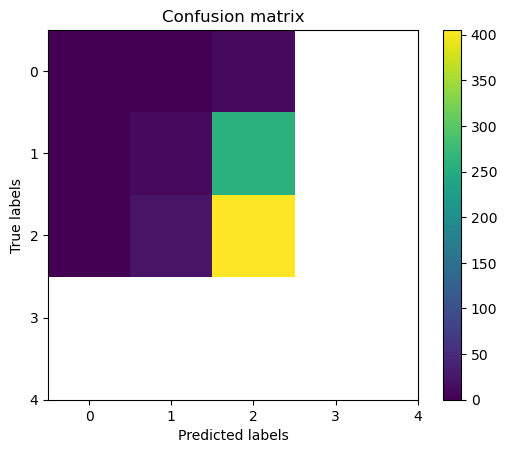

In [34]:
plt.imshow(confusion_mat_random, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
ticks = np.arange(5)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

<Axes: >

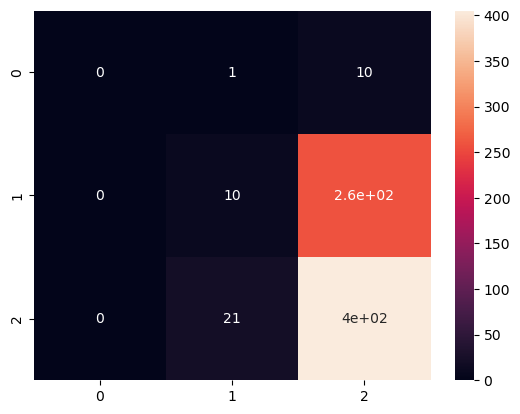

In [35]:
sns.heatmap(confusion_mat_random, annot=True)